# Demo: GPSR Using Bingo

## (1) Import Base Packages ##

In [15]:
import numpy as np;np.seterr(all="ignore")
import matplotlib.pyplot as plt
%matplotlib notebook
plt.rcParams["animation.html"] = "jshtml"
from IPython.display import display, clear_output
from tqdm import tqdm

## (2) Import Relevant Bingo Classes ##

In [16]:
#Classes for Genetic Programming (GP)
from bingo.symbolic_regression import ComponentGenerator
from bingo.evolutionary_optimizers.island import Island
from bingo.symbolic_regression.agraph.agraph import AGraph
from bingo.stats.pareto_front import ParetoFront

#Classes for the EVALUATION stage of GPSR
from bingo.symbolic_regression import ExplicitRegression, \
                                      ExplicitTrainingData
from bingo.evaluation.evaluation import Evaluation
from bingo.local_optimizers.continuous_local_opt import ContinuousLocalOptimization

#Classes for the EVOLUTION stage of GPSR
from bingo.symbolic_regression import AGraphGenerator, \
                                      AGraphCrossover, \
                                      AGraphMutation

#Classes for the SELECTION stage of GPSR
from bingo.evolutionary_algorithms.generalized_crowding import \
                                      GeneralizedCrowdingEA
from bingo.selection.deterministic_crowding import DeterministicCrowding

## (2) Initialize GPSR Hyperparameters ##
Note: Hyperparameters relating to the criterion check and information storage not present in this code. Refer to BingoExample/example_code/main_script.py for additional information.

In [17]:
POPULATION_SIZE = 104
STACK_SIZE = 24
MAX_GENERATIONS = 100

## (3) Make Training Data ##

<IPython.core.display.Javascript object>


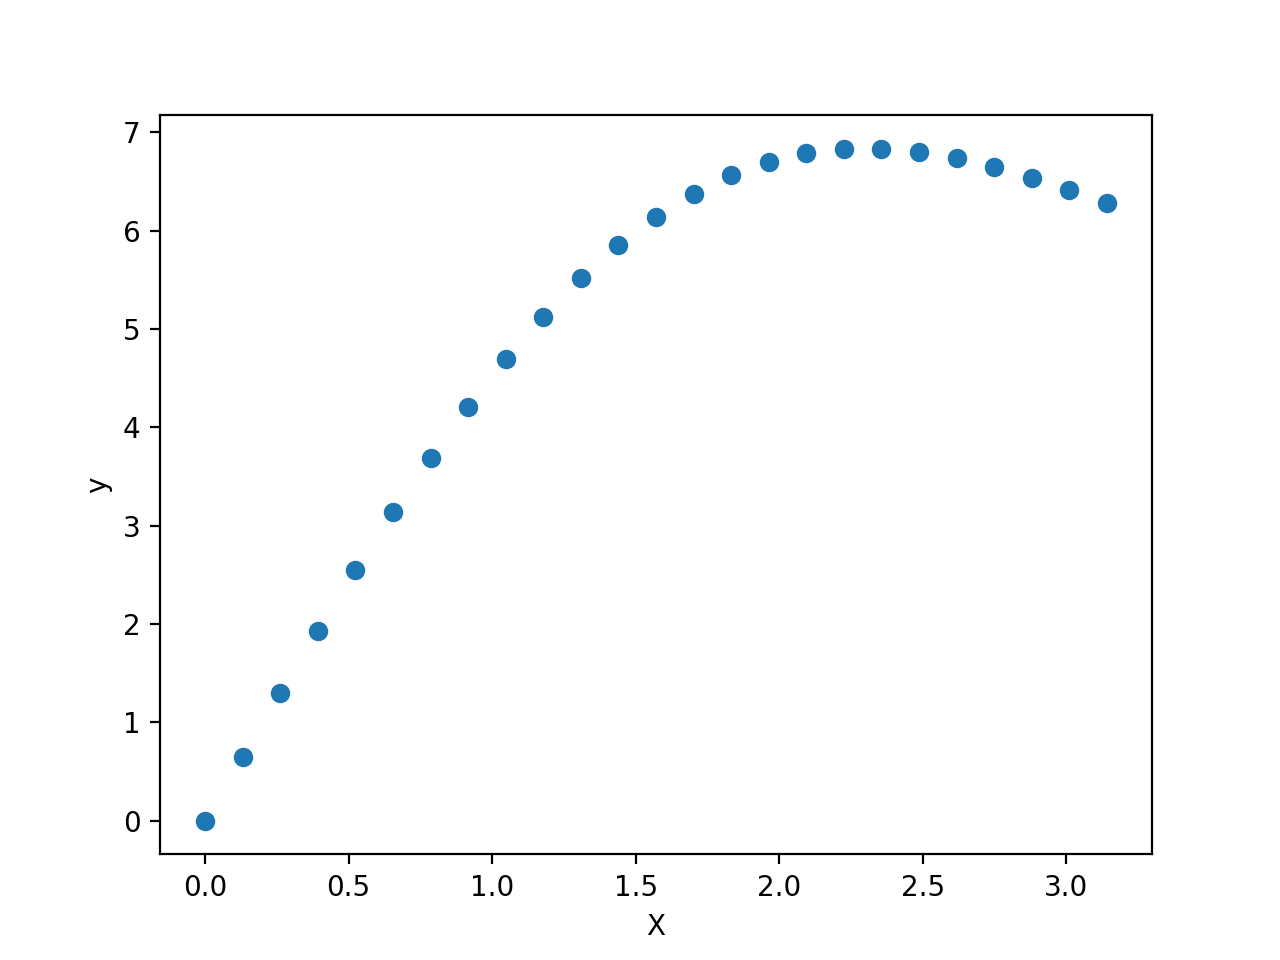

Text(0, 0.5, 'y')

In [18]:
model = AGraph(equation="3*sin(X_0) + 2*X_0")
X = np.linspace(0, np.pi, 25).reshape((-1,1))
y = model.evaluate_equation_at(X)
training_data = ExplicitTrainingData(x=X, y=y)
plt.scatter(X, y)
plt.xlabel("X")
plt.ylabel("y")

## (4) Initialize component generator, mutation and crossover objects, and AGraph generators ##

In [19]:
component_generator = ComponentGenerator(training_data.x.shape[1])
component_generator.add_operator("+")
component_generator.add_operator("-")
component_generator.add_operator("*")
component_generator.add_operator("sin")
component_generator.add_operator("cos")
component_generator.add_operator("exp")
component_generator.add_operator("pow")
component_generator.add_operator("sqrt")

crossover = AGraphCrossover()
mutation = AGraphMutation(component_generator)
agraph_generator = AGraphGenerator(STACK_SIZE, component_generator,
                                       use_simplification=True)

## (5) Initialize fitness metric, parameter optimizer, and evaluator ##

In [20]:
fitness = ExplicitRegression(training_data=training_data)
local_opt_fitness = ContinuousLocalOptimization(fitness, algorithm='lm')
evaluator = Evaluation(local_opt_fitness)#, multiprocess=4)

## (6) Initialize selection and evolutionary algorithm ##

In [21]:
selection_phase = DeterministicCrowding()
ea = GeneralizedCrowdingEA(evaluator, crossover,
                      mutation, 0.4, 0.4, selection_phase)

## (7) Initialize Bingo Island with Hall of Fame ##

In [22]:
def agraph_similarity(ag_1, ag_2):
    """a similarity metric between agraphs"""
    return ag_1.fitness == ag_2.fitness and ag_1.get_complexity() == ag_2.get_complexity()

pareto_front = ParetoFront(secondary_key=lambda ag: ag.get_complexity(),
                           similarity_function=agraph_similarity) 
def make_island():
    """
    Function created for repeated runs.
    """
    island = Island(ea, agraph_generator, POPULATION_SIZE, hall_of_fame=pareto_front)
    return island

## (8) Run GPSR and Visualize Results ##

In [23]:
# Simple Visualization Code

def plot_best_n_individuals(ax, island, n=10):
    ax.clear()
    fits = np.array([ind.fitness for ind in island.population])
    fits[np.isinf(fits)] = np.nan
    idxs = np.argsort(fits)[:n]
    for i in idxs:
        ind = island.population[i]
        ax.plot(X, ind.evaluate_equation_at(X)) 
    ax.scatter(X, y, color="k", label="Training Data")
    ax.legend()
    ax.set_xlabel("X")
    ax.set_ylabel("y")
    ax.set_ylim(0, 10)
    
def update_ax(ax, fig, x, y_mu, y_upper, y_lower):
    ax.clear()
    ax.set_ylim(0, 2.5)
    ax.set_xlabel("Generations")
    ax.set_ylabel("Mean Fitness")
    ax.plot(x, y_mu, color="b")
    ax.fill_between(x, y_upper, y_lower, color="b", alpha=0.3)
    

<IPython.core.display.Javascript object>


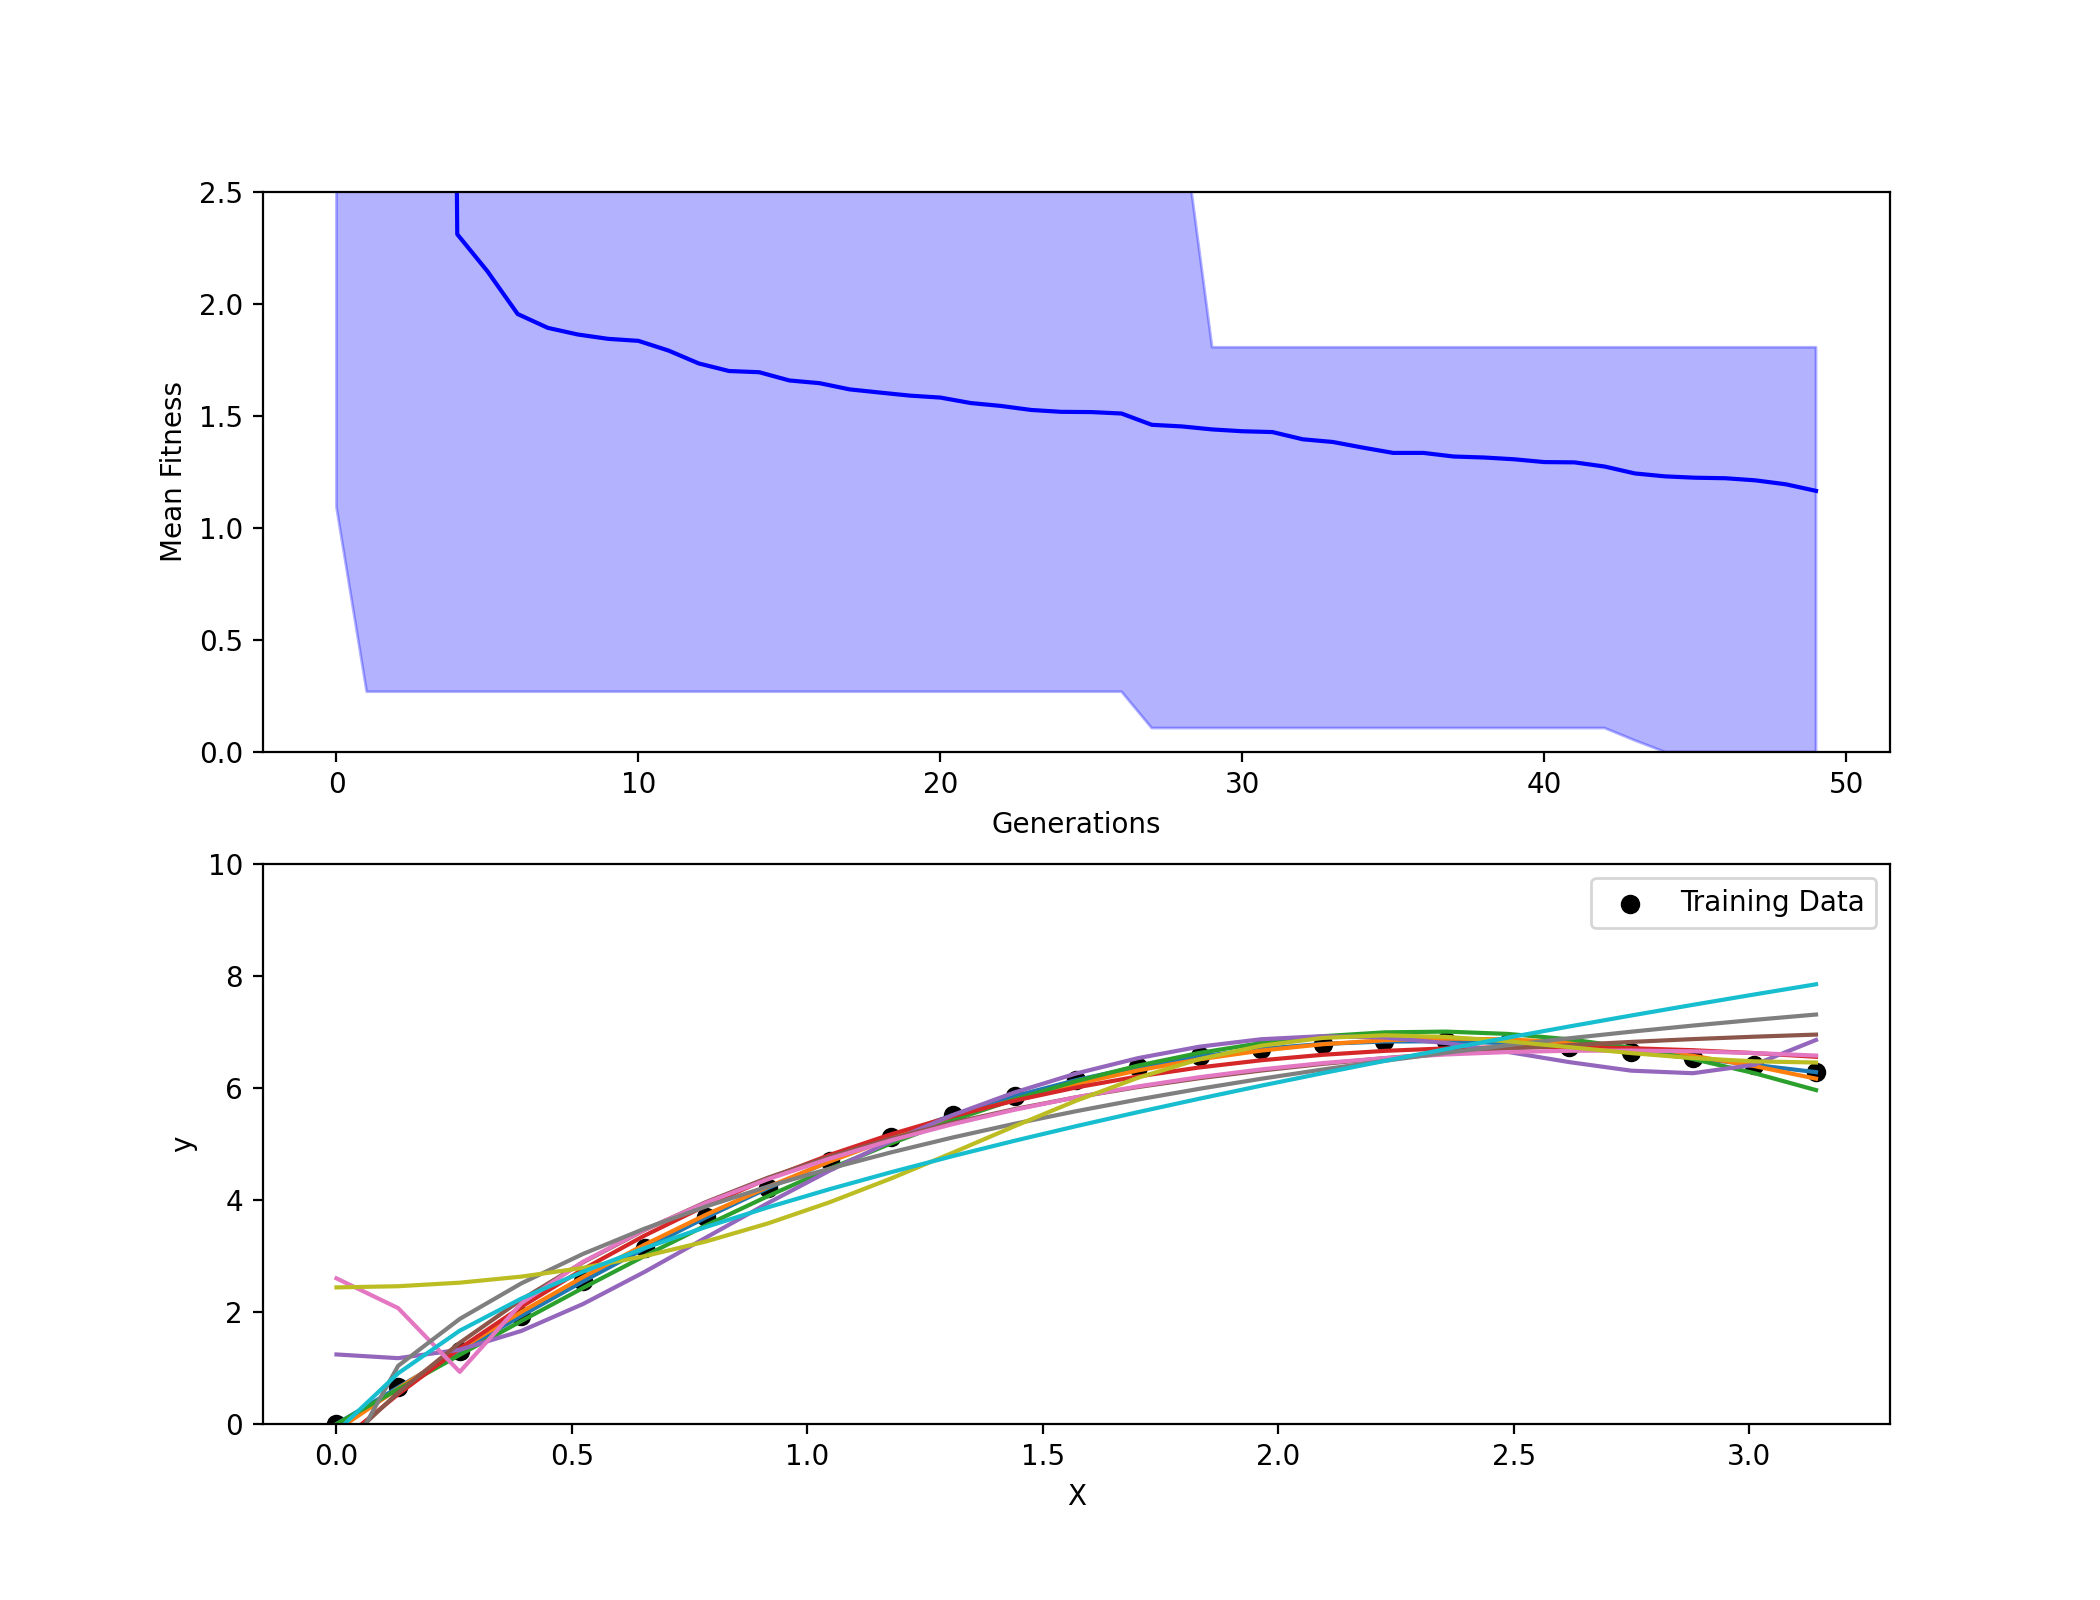

Text(0, 0.5, 'y')

In [24]:
fig, axs = plt.subplots(2, figsize=(10.5, 8))
axs[0].set_ylim(0, 1)
axs[1].scatter(X, y, color="k", label="Training Data")
axs[1].legend()
axs[0].set_ylim(0, 2.5)
axs[0].set_xlabel("Generations")
axs[0].set_ylabel("Mean Fitness")
axs[1].set_ylim(0, 10)
axs[1].set_xlabel("X")
axs[1].set_ylabel("y")

In [ ]:
island = make_island()
#fig, axs = plt.subplots(2, figsize=(10.5, 8))
plt.show()
axs[0].set_xlabel("X")
axs[0].set_ylabel("y")

print("Best individual at initialization\n f(X_0) =", island.get_best_individual())
best_indv_values = []
best_indv_values.append(island.get_best_individual())
best_indv_gen = []
best_indv_gen.append(island.generational_age)
fits = [ind.fitness for ind in island.population]
means = [np.nanmean(fits)]
maxs = [np.nanmax(fits)]
mins = [np.nanmin(fits)]
fig.canvas.draw()

for i in tqdm(range(MAX_GENERATIONS)):
    island.evolve(1)
    best_indv = island.get_best_individual()
    if best_indv.fitness < best_indv_values[-1].fitness:
        best_indv_values.append(best_indv)
        best_indv_gen.append(island.generational_age)
        print(f"Best individual at generation {island.generational_age}\n f(X_0) =", island.get_best_individual())
    fits = np.array([ind.fitness for ind in island.population])
    fits[np.isinf(fits)] = np.nan
    means += [np.nanmean(fits)]
    maxs += [np.nanmax(fits)]
    mins += [np.nanmin(fits)]
    update_ax(axs[0], fig, np.arange(island.generational_age+1), np.array(means), np.array(maxs), np.array(mins))
    plot_best_n_individuals(axs[1], island, n=10)
    fig.canvas.draw()


Best individual at initialization
 f(X_0) = 3.4016425293867614 + X_0


  0%|                                                   | 0/100 [00:00<?, ?it/s]

Best individual at generation 1
 f(X_0) = (-7.662210270251392)(-0.9390865890578225 + (0.3328787444691555)^(X_0))


 27%|███████████▎                              | 27/100 [00:06<00:17,  4.22it/s]

Best individual at generation 27
 f(X_0) = (7.0088656888206256)(sin((0.6761753219454544)(X_0)))


 43%|██████████████████                        | 43/100 [00:10<00:14,  4.03it/s]

Best individual at generation 43
 f(X_0) = (1.2353075718971558)(-0.09429769713927832 + (X_0)(4.760622638914377 - (X_0)))
Best individual at generation 44
 f(X_0) = (0.5)(X_0) + (3.0)((0.5)(X_0) + sin(X_0))


 49%|████████████████████▌                     | 49/100 [00:11<00:12,  4.23it/s]

## Print Hall of Fame ###

In [14]:
for ind in island.hall_of_fame:
    print(f"model (fitness={ind.fitness}), fitness: {str(ind)}, {ind.fitness}")

model (fitness=4.440892098500626e-16), fitness: (2.9999999999999973)((0.6666666666666677)(X_0) + sin((1.0000000000000004)(X_0))), 4.440892098500626e-16
model (fitness=0.051638189660022864), fitness: -0.11648665928861593 + (X_0)(5.880833192795952 + (-1.2353075718971562)(X_0)), 0.051638189660022864
model (fitness=0.17766858292807305), fitness: X_0 - ((-4.202145308604981 + X_0)(0.0605526550151879 + X_0)), 0.17766858292807305
model (fitness=0.2946054566865359), fitness: (2.2499500755675514)(X_0 + sin(X_0)), 0.2946054566865359
model (fitness=0.5525787802048469), fitness: (4.28540930350571)(sqrt(X_0)), 0.5525787802048469
model (fitness=1.0353556236894652), fitness: 3.945375982138026 + X_0, 1.0353556236894652
model (fitness=1.6546229275819522), fitness: 6.3976570423702395, 1.6546229275819522
